<a href="https://colab.research.google.com/github/FiyonaK/Project-2/blob/main/Project_2_Part_3(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stroke Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load data
df_str = pd.read_csv('/content/drive/MyDrive/CodingDojo/03-AdvancedML/Week09/Data/healthcare-dataset-stroke-data.csv')

df_str.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


1. Source of data:

  https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

2. Brief description of data:

  According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
  This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status

3. What is the target?  

  stroke: 1 if the patient had a stroke or 0 if not

4. What does one row represent? (A person? A business? An event? A product?)

  Each row in the data provides relavant information about the patient.

5. Is this a classification or regression problem?

  Classification

In [3]:
df_str.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


6. How many features does the data have?

  12 columns/features

7. How many rows are in the dataset?

  5110

8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

Possible imbalance of data and finding the right techqinues/parameters to model an imbalanced dataset correctly.
Deciding the correct standardization, imputation and modeling strategies to use to get the most accurate predictions.

##Data Cleaning

In [4]:
#Delete unnecessary columns
df_str = df_str.drop(columns = ['id', 'Residence_type'])
df_str.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,174.12,24.0,never smoked,1


Note: I chose to leave the 'married' column in as I am intrigued to see the effect of marriage (or not) on stroke prediction.

Also left work_type in as I believe this could also have an impact on the predictions.

In [5]:
#Check for duplicate rows.
df_str.duplicated().sum()

0

There are no duplicate rows to delete

In [6]:
#Check the data balance
df_str['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [7]:
#Identify missing values.
df_str.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

bmi column has 201 missing values, which we will impute with median since we seem to have an extemely imbalanced dataset.

In [8]:
#Impute missing values in bmi column with median
df_str['bmi'] = df_str['bmi'].fillna(df_str['bmi'].median())

In [9]:
#Confirm that there are no more missing values
df_str.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [10]:
#Identify inconsistencies in data for categorical values (i.e. Cat, cat, cats).
#Display value counts for categorical columns
for col in df_str.select_dtypes(include='object').columns:
  display(df_str[col].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Yes    3353
No     1757
Name: ever_married, dtype: int64

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

There are no inconsistent categories in the categorical columns.

###Produce univariate visuals for the target and all features.

In [11]:
#Univariate EDA Functions

# UNIVARIATE PLOTTING FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source: https://login.codingdojo.com/m/717/16237/120173
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source: https://login.codingdojo.com/m/717/16237/120173
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


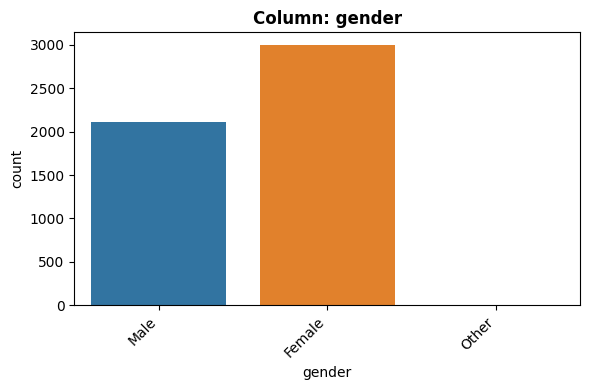

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Female' occurs 2994 times (58.59%)
- Not constant or quasi-constant.


In [12]:
#Plot Univariate visual for gender column
explore_categorical(df_str, 'gender', fillna=False);

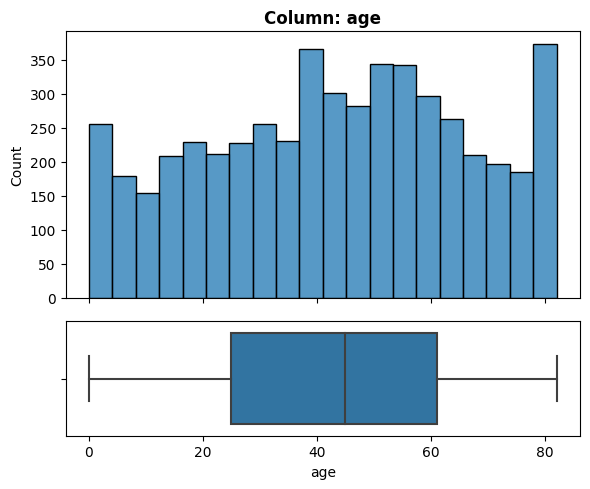

- NaN's Found: 0 (0.0%)
- Unique Values: 104
- Most common value: '78.0' occurs 102 times (2.0%)
- Not constant or quasi-constant.


In [13]:
#Plot Univariate visuals for age column
explore_numeric(df_str, 'age');

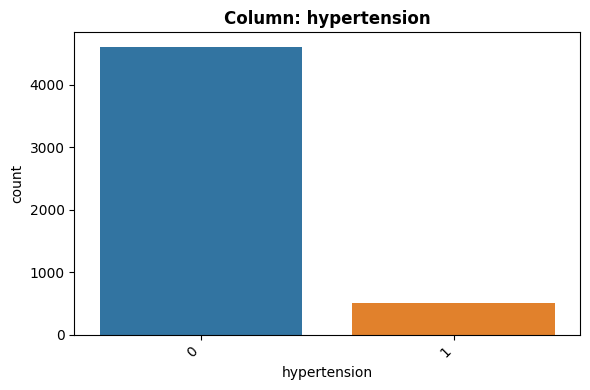

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 4612 times (90.25%)
- Not constant or quasi-constant.


In [15]:
#Plot Univariate visuals for hypertension column
explore_categorical(df_str, 'hypertension', fillna=False);

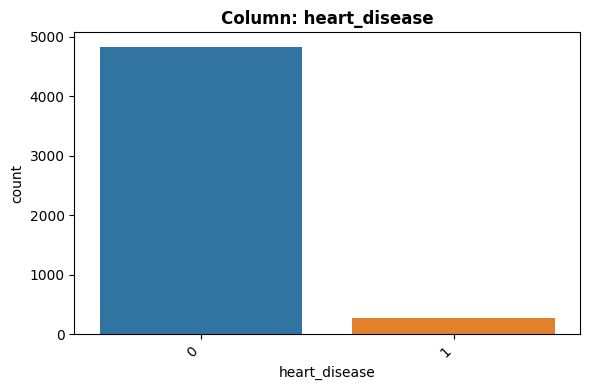

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 4834 times (94.6%)
- Not constant or quasi-constant.


In [16]:
#Plot Univariate visuals for heart_disease column
explore_categorical(df_str, 'heart_disease', fillna=False);

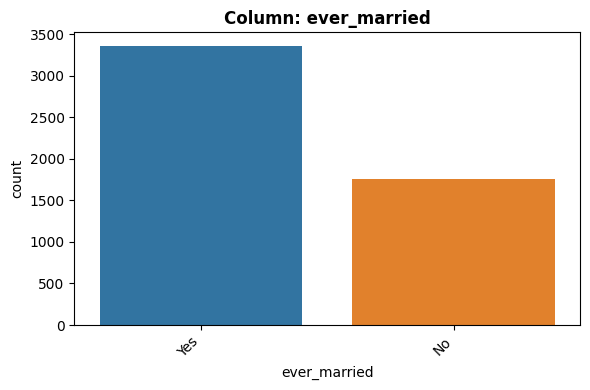

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Yes' occurs 3353 times (65.62%)
- Not constant or quasi-constant.


In [17]:
#Plot Univariate visuals for ever_married column
explore_categorical(df_str, 'ever_married', fillna=False);

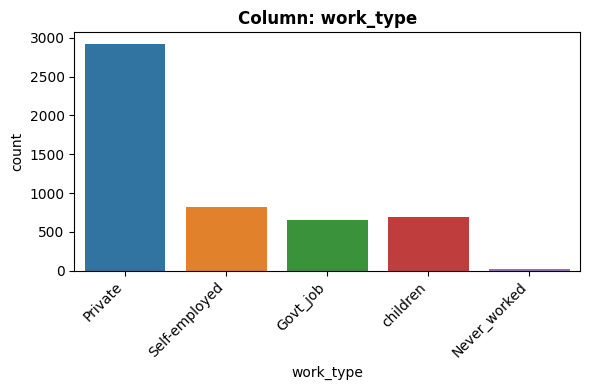

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'Private' occurs 2925 times (57.24%)
- Not constant or quasi-constant.


In [18]:
#Plot Univariate visuals for work_type column
explore_categorical(df_str, 'work_type', fillna=False);

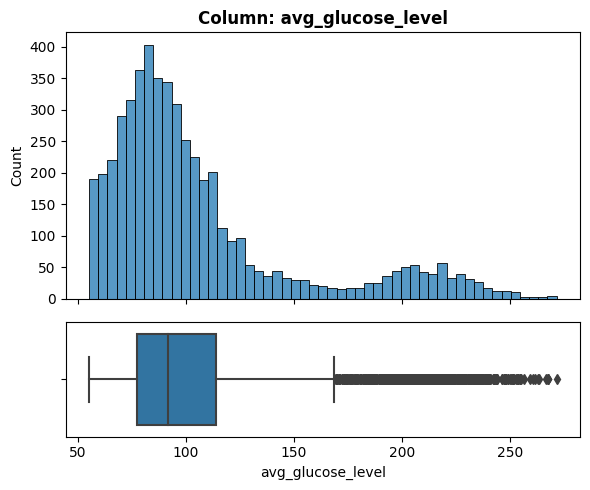

- NaN's Found: 0 (0.0%)
- Unique Values: 3979
- Most common value: '93.88' occurs 6 times (0.12%)
- Not constant or quasi-constant.


In [19]:
#Plot Univariate visuals for avg_glucose_level column
explore_numeric(df_str, 'avg_glucose_level');

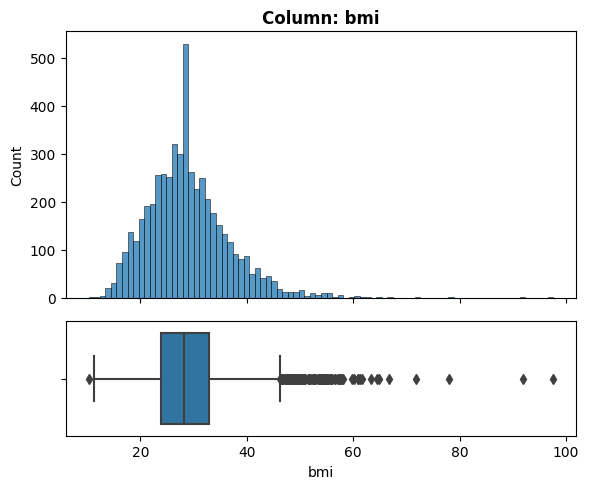

- NaN's Found: 0 (0.0%)
- Unique Values: 418
- Most common value: '28.1' occurs 230 times (4.5%)
- Not constant or quasi-constant.


In [20]:
#Plot Univariate visuals for bmi column
explore_numeric(df_str, 'bmi');

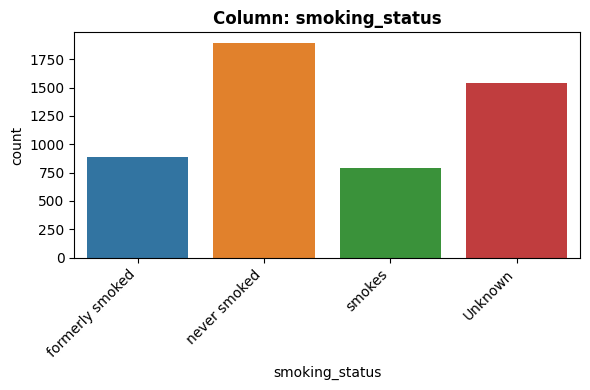

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'never smoked' occurs 1892 times (37.03%)
- Not constant or quasi-constant.


In [21]:
#Plot Univariate visuals for smoking_status column
explore_categorical(df_str, 'smoking_status', fillna=False);

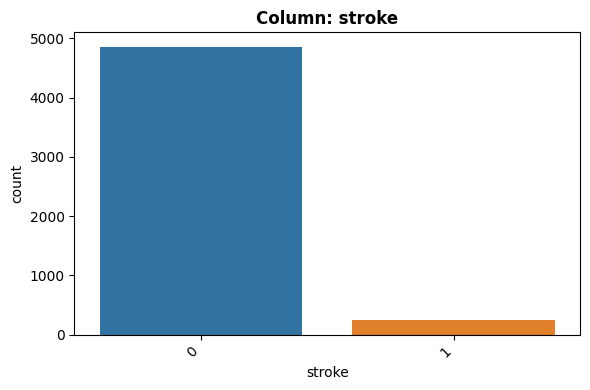

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 4861 times (95.13%)
- Not constant or quasi-constant.


In [22]:
#Plot Univariate visuals for stroke column
explore_categorical(df_str, 'stroke', fillna=False);

In [23]:
#Identify outliers.
df_str.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.862035,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.699562,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


As can be seen from the boxplots and descriptive statistics above, we have some outliers in the following columns:
  - age:
    
    Age column has a minimum value of 0.08. Presuming this data is for adults only, this is an impossible value.

  - avg_glucose_level:
    
    Lots of outliers in this column. Also has a maximum value of 271 which is very high but not impossible. This glucose level would require immediate medical attention.

  - bmi:

    bmi has an almost impossible minimum and maximum value. A min value of 10 would indicate the person is severely underweight and could be life threatening, while a max value of 97.6 is highly improbable. Generally speaking, a BMI of between 40 and 69 already indicates morbid obesity.

###Identify any moderate or strong correlations between your target and your features and/or between one feature and another using a correlation heatmap.


In [24]:
corr = df_str.corr()
corr.round(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.00,0.28,0.26,0.24,0.32,0.25
hypertension,0.28,1.00,0.11,0.17,0.16,0.13
heart_disease,0.26,0.11,1.00,0.16,0.04,0.13
avg_glucose_level,0.24,0.17,0.16,1.00,0.17,0.13
bmi,0.32,0.16,0.04,0.17,1.00,0.04
stroke,0.25,0.13,0.13,0.13,0.04,1.00


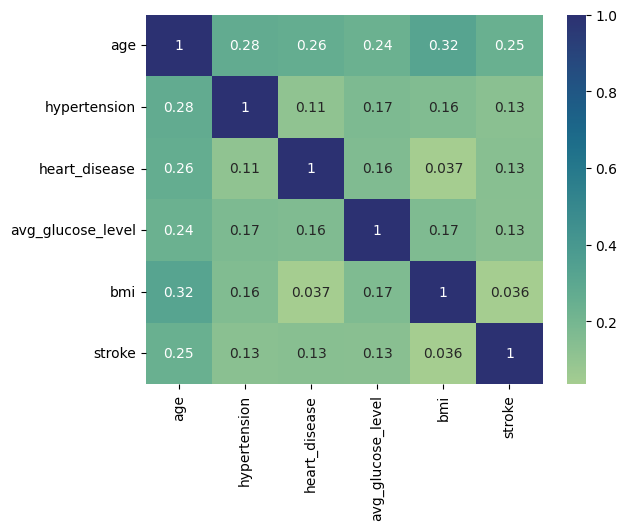

In [25]:
ax = sns.heatmap(corr, cmap = 'crest', annot = True)

Interpretation: There seems to be a moderate positive correlation of all the numeric features against the age feature.

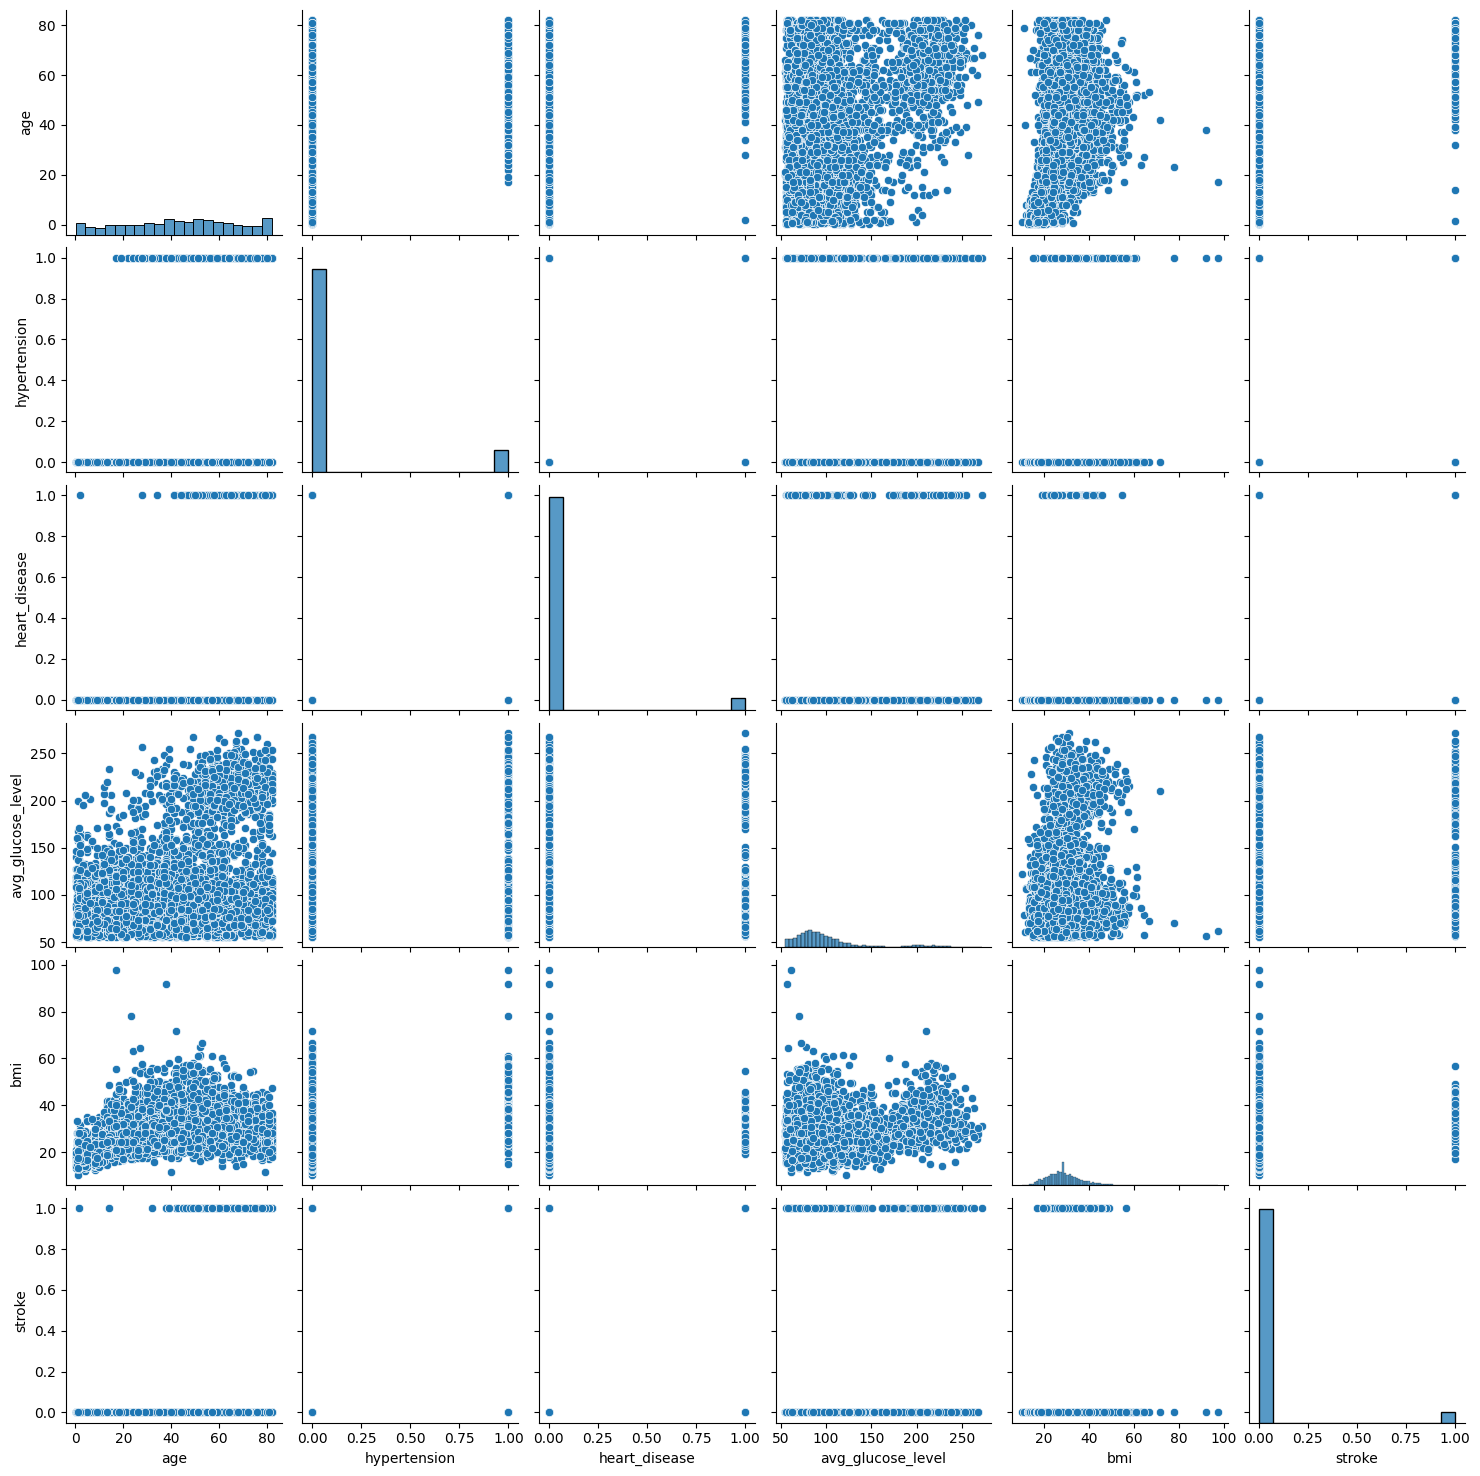

In [27]:
#Using sns pairplot to plot the relationships between all numeric variables
sns.pairplot(df_str);

Source: https://www.kdnuggets.com/2022/04/data-visualization-python-seaborn.html

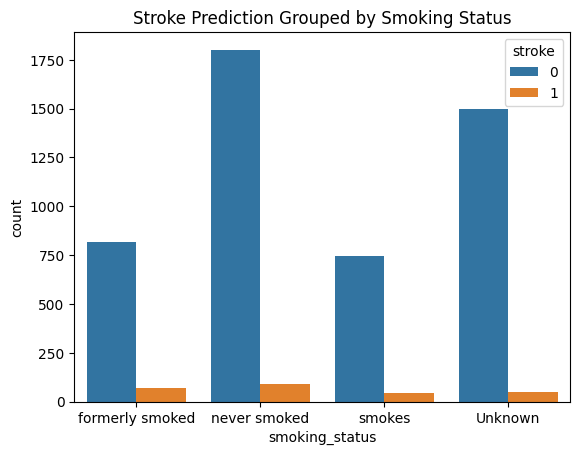

In [79]:
ax = sns.countplot(data=df_str, hue='stroke', x='smoking_status')
ax.set_title("Stroke Prediction Grouped by Smoking Status");

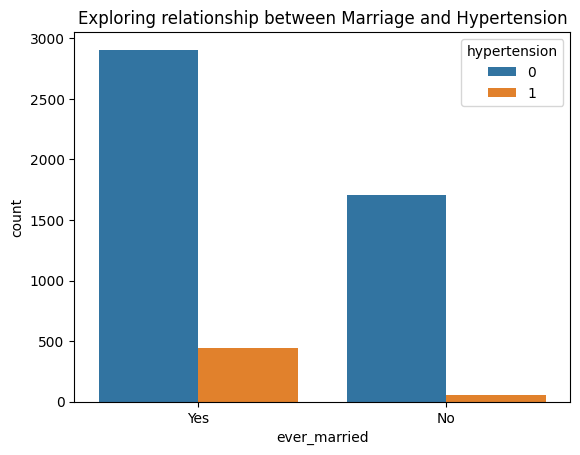

In [80]:
ax = sns.countplot(data=df_str, hue='hypertension', x='ever_married')
ax.set_title("Exploring relationship between Marriage and Hypertension");

Just as suspected! Marriage is a higher contributing factor to hypertension vs not married.

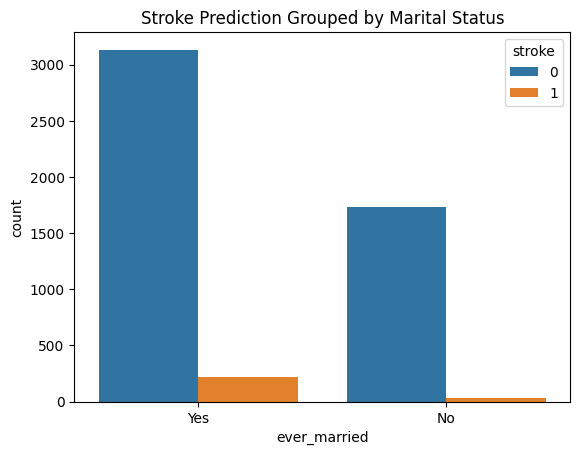

In [81]:
ax = sns.countplot(data=df_str, hue='stroke', x='ever_married')
ax.set_title("Stroke Prediction Grouped by Marital Status");

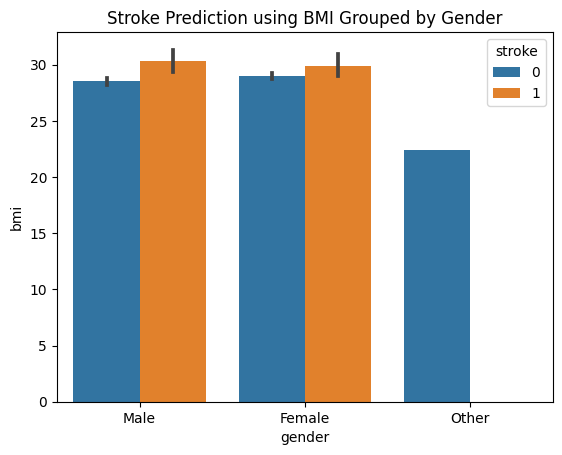

In [83]:
ax = sns.barplot(data=df_str, y="bmi", x="gender", hue='stroke')

ax.set_title("Stroke Prediction using BMI Grouped by Gender");

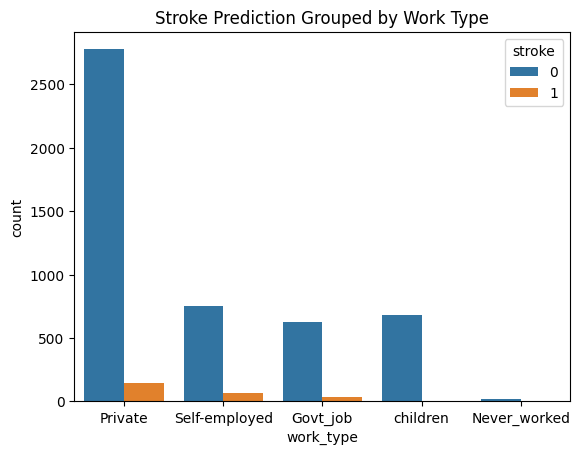

In [82]:
ax = sns.countplot(data=df_str, hue='stroke', x='work_type')
ax.set_title("Stroke Prediction Grouped by Work Type");

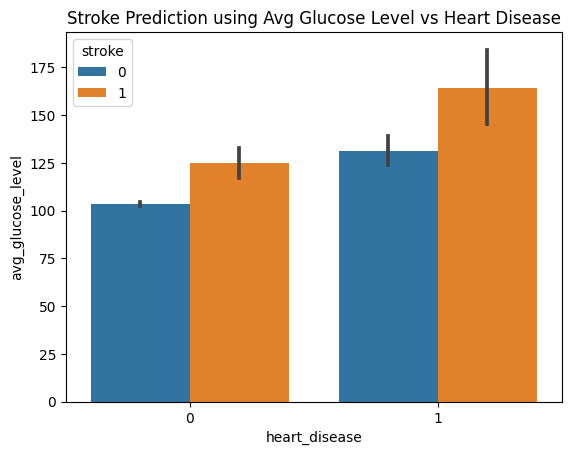

In [84]:
ax = sns.barplot(data=df_str, y="avg_glucose_level", x="heart_disease", hue='stroke')

ax.set_title("Stroke Prediction using Avg Glucose Level vs Heart Disease");

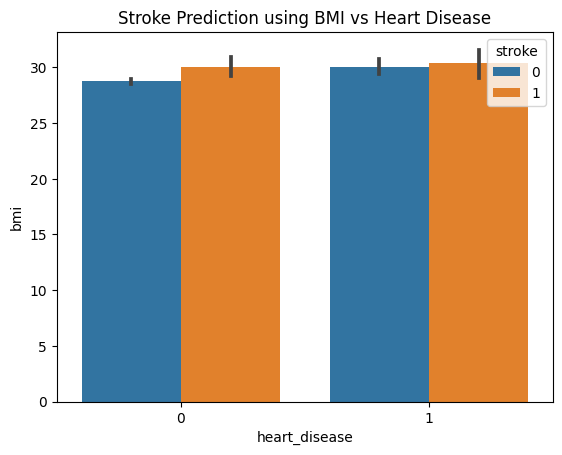

In [97]:
ax = sns.barplot(data=df_str, y="bmi", x="heart_disease", hue='stroke')

ax.set_title("Stroke Prediction using BMI vs Heart Disease");

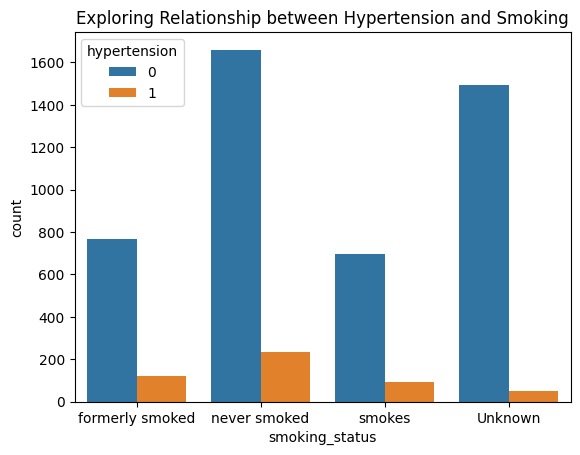

In [94]:
ax = sns.countplot(data=df_str, hue='hypertension', x='smoking_status')

ax.set_title("Exploring Relationship between Hypertension and Smoking");

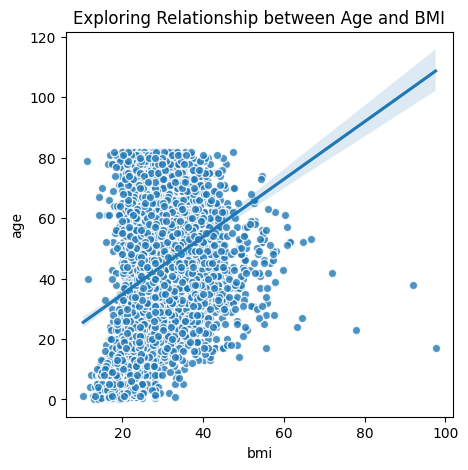

In [96]:
  fig, ax = plt.subplots(figsize=(5,5))
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df_str, x='bmi', y='age', ax=ax, scatter_kws=scatter_kws)
  ax.set_title("Exploring Relationship between Age and BMI");

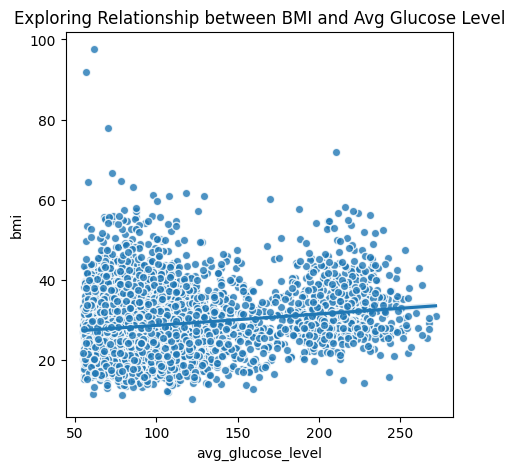

In [95]:
  fig, ax = plt.subplots(figsize=(5,5))
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df_str, x='avg_glucose_level', y='bmi', ax=ax, scatter_kws=scatter_kws)
  ax.set_title("Exploring Relationship between BMI and Avg Glucose Level");

###Choose two visualizations from your analysis that demonstrate key trends you found that will be of interest to a stakeholder.

####VISUAL 1 - Glucose Level vs Heart Disease

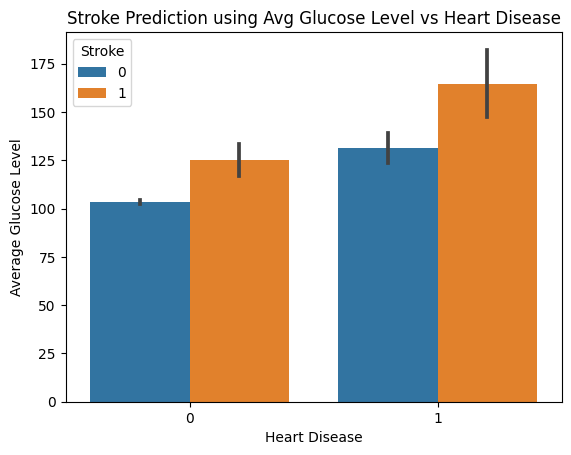

In [109]:
ax = sns.barplot(data=df_str, y="avg_glucose_level", x="heart_disease", hue='stroke')

plt.xlabel("Heart Disease")
plt.ylabel("Average Glucose Level")
plt.legend(title='Stroke')
ax.set_title("Stroke Prediction using Avg Glucose Level vs Heart Disease")
plt.show();

In this visual we explored the relationship between a person's average glucose level and heart disease in predicting a stroke. Interestingly enough, in both cases, a higher average glucose level seems to contribute to a stroke, regardless of whether the individual presents with heart disease or not.

Additionally, it should be noted that higher average glucose levels also contribute to the development of heart disease in an individual.

####VISUAL 2 - Hypertension vs Smoking

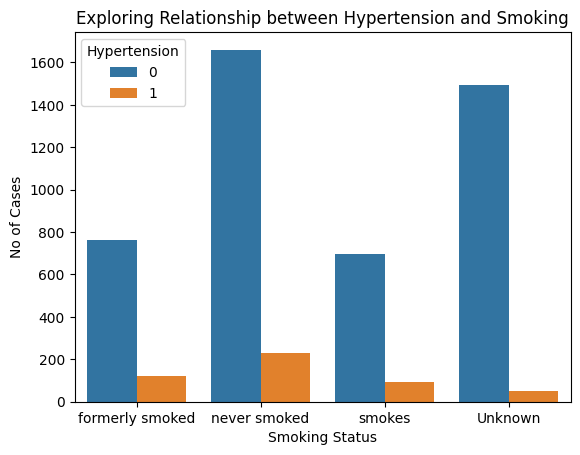

In [111]:
ax = sns.countplot(data=df_str, hue='hypertension', x='smoking_status')

plt.xlabel("Smoking Status")
plt.ylabel("No of Cases")
plt.legend(title='Hypertension')
ax.set_title("Exploring Relationship between Hypertension and Smoking")
plt.show();

In the above visual we explored the relationship between smoking and hypertension. As can be seen from the above, the highest number of hypertensive cases presented in those who have never smoked! There are lower cases of hypertension in those that currently smoke, and those who have stopped smoking.

This is the complete opposite to what was expected. It seems that, according to our data, smoking does not play a big part in causing hypertension, if at all.

#Adult Income

In [ ]:
#Load data
df_inc = pd.read_csv('/content/drive/MyDrive/CodingDojo/03-AdvancedML/Week09/Data/adult.csv')

df_inc.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


1. Source of data:

  https://www.kaggle.com/datasets/wenruliu/adult-income-dataset

2. Brief description of data:

  An individual’s annual income results from various factors. Intuitively, it is influenced by the individual’s education level, age, gender, occupation, and etc.
  This is a widely cited KNN dataset, useful in predicting income level based on the individual’s personal information.

3. What is the target?  

  Income: <=50K or >50K

4. What does one row represent? (A person? A business? An event? A product?)

  Each row in the data represents a person and their information

5. Is this a classification or regression problem?

  Classification

In [ ]:
df_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


6. How many features does the data have?

  15 columns/features

7. How many rows are in the dataset?

  48842

8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

Possible imbalance of data and finding the right techqinues/parameters to model an imbalanced dataset correctly.
Deciding the correct standardization, imputation and modeling strategies to use to get the most accurate predictions.